# Implementation of the solution to project 2 from scratch
To note:
- For clarity the df_test was renamed to df_val as the test word was used when splitting the labeled data into train and test. 
    - Val stands for validation

To try out:
- Preprocessing
    - Tweak data imputer
    - Tweak scaler (Robust scaler, minmax, etc..)
    - Tweak feature selection parameter
    - Tweak order of operations above to see the effect
- Modelling
    - XGBoost
    - SVM

## Import modules

In [7]:
from __future__ import print_function

import argparse
import logging
import os
import shutil
import sys
import zipfile
import time
import sys
import torch

import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from collections import Counter
from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.under_sampling import ClusterCentroids, RandomUnderSampler

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.feature_selection import SelectKBest, f_regression, chi2, f_classif
from sklearn.metrics import f1_score, mean_squared_error, accuracy_score, r2_score, roc_auc_score, recall_score, precision_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import label_ranking_average_precision_score as LRAPS
from sklearn.metrics import label_ranking_loss as LRL
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, BayesianRidge, LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## Define global variables

In [8]:
# Global variables
IDENTIFIERS = ["pid", "Time"]
MEDICAL_TESTS = [
    "LABEL_BaseExcess",
    "LABEL_Fibrinogen",
    "LABEL_AST",
    "LABEL_Alkalinephos",
    "LABEL_Bilirubin_total",
    "LABEL_Lactate",
    "LABEL_TroponinI",
    "LABEL_SaO2",
    "LABEL_Bilirubin_direct",
    "LABEL_EtCO2",
]
VITAL_SIGNS = ["LABEL_RRate", "LABEL_ABPm", "LABEL_SpO2", "LABEL_Heartrate"]
SEPSIS = ["LABEL_Sepsis"]
ESTIMATOR = {"bayesian": BayesianRidge(), "decisiontree": DecisionTreeRegressor(max_features="sqrt", random_state=0), 
                "extratree": ExtraTreesRegressor(n_estimators=10, random_state=0), 
                "knn": KNeighborsRegressor(n_neighbors=10, weights="distance")}

FEATURES_MNAR = ["EtCO2", "PTT", "BUN", "Lactate", "Hgb", "HCO3", "BaseExcess",
                          "Fibrinogen", "Phosphate", "WBC", "Creatinine", "PaCO2", "AST",
                          "FiO2", "Platelets", "SaO2", "Glucose", "Magnesium", "Potassium",
                          "Calcium", "Alkalinephos", "Bilirubin_direct", "Chloride", "Hct",
                          "Bilirubin_total", "TroponinI", "pH"]

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cpu


In [9]:
def sigmoid_f(x):
    """To get predictions as confidence level, the model predicts for all 12 sets of measures for
    each patient a distance to the hyperplane ; it is then transformed into a confidence level using
    the sigmoid function ; the confidence level reported is the mean of all confidence levels for a
    single patient

    Args:
        x (float): input of the sigmoid function

    Returns:
       float: result of the sigmoid computation.

    """
    return 1 / (1 + np.exp(-x))

## Load Data

In [153]:
df_train = pd.read_csv(r"data/train_features.csv")
df_train_label = pd.read_csv(r"data/train_labels.csv")
df_val = pd.read_csv(r"data/test_features.csv")

## Data imputation methodology

In [47]:
# Adding engineered features
mnar_columns = [
        sub + "_presence" for sub in FEATURES_MNAR
    ]
pid = df_train["pid"].unique()
patient_count = -1
for patient in pid:
    patient_count += 1
    print(patient_count/len(pid)*100, end="\r")
    for column in FEATURES_MNAR:
        presence = int(df_train.loc[
            df_train["pid"] == patient
            ][column].any())
        df_train.at[patient, column] = presence
print("Done adding features about MNAR features")

Done adding features about MNAR features


In [48]:
# Adding engineered features
pid = df_val["pid"].unique()
patient_count = -1
for patient in pid:
    patient_count += 1
    print(patient_count/len(pid)*100, end="\r")
    for column in FEATURES_MNAR:
        presence = int(df_val.loc[
            df_val["pid"] == patient
            ][column].any())
        df_val.at[patient, column] = presence
print("Done adding features about MNAR features")

Done adding features about MNAR features


In [49]:
columns_for_regression = ["Temp", "Hgb", "RRate", "BaseExcess", "WBC", "PaCO2", "FiO2", "Glucose", "ABPm", "ABPd", "SpO2", "Hct", "Heartrate", "ABPs", "pH"]
columns_for_regression_trend = [
        sub + "_trend" for sub in columns_for_regression
    ]
columns_for_regression_std = [
        sub + "_std" for sub in columns_for_regression
    ]
columns_for_regression_min = [
        sub + "_min" for sub in columns_for_regression
    ]
columns_for_regression_max = [
        sub + "_max" for sub in columns_for_regression
    ]
cols_to_add = columns_for_regression_trend + columns_for_regression_std + columns_for_regression_min + columns_for_regression_max
patient_count = 0

df_train = df_train.reindex(
        df_train.columns.tolist() + cols_to_add,
        axis=1,
    )

pid = df_train["pid"].unique()

for patient in pid:
    patient_count += 1
    print(patient_count/len(pid)*100, end="\r")
    for column in columns_for_regression:
        if df_train.loc[df_train["pid"] == patient][column].isna().sum() <= 8:
            series = df_train.loc[df_train["pid"] == patient][column]
            # Fill missing values between two non nans with their average
            series = (series.ffill() + series.bfill()) / 2
            # Drop the rest of the value
            series = series.dropna()
            standard_deviation = series.std()
            minimum = series.min()
            maximum = series.max()
            X = [i for i in range(0, len(series))]
            X = np.reshape(X, (len(X), 1))
            y = series
            model = LinearRegression()
            try:
                model.fit(X, y)
                df_train.at[patient, column + "_trend"] = model.coef_
            except ValueError:
                df_train.at[patient, column + "_trend"] = 0
            df_train.at[patient, column + "_std"] = standard_deviation
            df_train.at[patient, column + "_min"] = minimum
            df_train.at[patient, column + "_max"] = maximum

    # fill rest of values with 0 for trends col umns
    df_train[columns_for_regression_trend] = df_train[
        columns_for_regression_trend
    ].fillna(value=0)
    df_train[columns_for_regression_std] = df_train[
        columns_for_regression_std
    ].fillna(value=0)
    df_train[columns_for_regression_min] = df_train[
        columns_for_regression_min
    ].fillna(value=0)
    df_train[columns_for_regression_max] = df_train[
        columns_for_regression_max
    ].fillna(value=0)

In [53]:
patient_count = 0

for patient in pid:
    patient_count += 1
    print(patient_count/len(pid)*100, end="\r")
    for column in columns_for_regression:
        if df_val.loc[df_val["pid"] == patient][column].isna().sum() <= 8:
            series = df_val.loc[df_train["pid"] == patient][column]
            # Fill missing values between two non nans with their average
            series = (series.ffill() + series.bfill()) / 2
            # Drop the rest of the value
            series = series.dropna()
            standard_deviation = series.std()
            minimum = series.min()
            maximum = series.max()
            X = [i for i in range(0, len(series))]
            X = np.reshape(X, (len(X), 1))
            y = series
            model = LinearRegression()
            try:
                model.fit(X, y)
                df_train.at[patient, column + "_trend"] = model.coef_
            except ValueError:
                df_train.at[patient, column + "_trend"] = 0
            df_val.at[patient, column + "_std"] = standard_deviation
            df_val.at[patient, column + "_min"] = minimum
            df_val.at[patient, column + "_max"] = maximum

    # fill rest of values with 0 for trends col umns
    df_val[columns_for_regression_trend] = df_val[
        columns_for_regression_trend
    ].fillna(value=0)
    df_val[columns_for_regression_std] = df_val[
        columns_for_regression_std
    ].fillna(value=0)
    df_val[columns_for_regression_min] = df_val[
        columns_for_regression_min
    ].fillna(value=0)
    df_val[columns_for_regression_max] = df_val[
        columns_for_regression_max
    ].fillna(value=0)

In [54]:
imputer = IterativeImputer()
columns = df_train.columns
df_train = imputer.fit_transform(df_train.values)
df_train = pd.DataFrame(df_train, columns=columns)
df_train = df_train.groupby(["pid"], as_index=False).mean()

# Tranform test data according to same imputer
pid_val = df_val["pid"].unique()
columns = df_val.columns
df_val = pd.DataFrame(columns=columns, index=pid_val)
df_val = imputer.transform(df_val.values)
df_val = pd.DataFrame(df_val, columns=columns)
df_val = df_val.groupby(["pid"], as_index=False).mean()

/home/philiphartout/anaconda3/envs/iml/lib/python3.7/site-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [55]:
df_train.to_csv("df_train_philip.csv")
df_val.to_csv("df_val_philip.csv")

## Data formatting

In [220]:
df_train_preprocessed = pd.read_csv("df_train_philip.csv")
df_val_preprocessed = pd.read_csv("df_val_philip.csv")

In [221]:
val_pids = np.unique(df_val_preprocessed["pid"].values)

In [222]:
df_train_preprocessed = df_train_preprocessed.sort_values(by=["pid"])
df_train_preprocessed = df_train_preprocessed.drop(columns=IDENTIFIERS)
df_val_preprocessed = df_val_preprocessed.sort_values(by=["pid"])
df_val_preprocessed = df_val_preprocessed.drop(columns=IDENTIFIERS)
df_train_label = df_train_label.sort_values(by=["pid"])

In [229]:
# Data formatting
X_train = df_train_preprocessed.values
X_val = df_val_preprocessed.values
# Create list with different label for each medical test
print("Creating a list of labels for each medical test")
y_train_medical_tests = []
for test in MEDICAL_TESTS:
    y_train_medical_tests.append(df_train_label[test].astype(int).values)

# Create list with different label for sepsis
print("Creating a list of labels for sepsis")
y_train_sepsis = []
for sepsis in SEPSIS:
    y_train_sepsis.append(df_train_label[sepsis].astype(int).values)

# Create list with different label for each vital sign
print("Creating a list of labels for each vital sign")
y_train_vital_signs = []
for sign in VITAL_SIGNS:
    y_train_vital_signs.append(df_train_label[sign].astype(int).values)

Creating a list of labels for each medical test
Creating a list of labels for sepsis
Creating a list of labels for each vital sign


## Scaler

In [230]:
# Scale data 
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

## Modelling medical tests

In [115]:
# # Modelling of medical tests using logistic regression with cross validation
# models = []
# losses = []
# columns_medical_tests = []
# for i, test in enumerate(MEDICAL_TESTS):
#     print(f"Fitting model for {test}.")

#     print("Applying feature selection")
#     feature_selector = SelectKBest(score_func=f_classif, k=3)
#     X_train = feature_selector.fit_transform(X_train, y_train_medical_tests[i])
#     X_test = feature_selector.transform(X_test)
#     columns = feature_selector.get_support(indices=True)
#     columns_medical_tests.append(columns)

#     print("Fitting model")
#     clf = LogisticRegressionCV(cv=5, random_state=42).fit(X_train, y_train_medical_tests[i])
#     models.append(clf)
#     print(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
#     print(f"Finished test for medical tests.")

In [116]:
print("READY TO ROLL")

READY TO ROLL


In [24]:
def convert_to_cuda_tensor(X_train, X_test, y_train, y_test, device):
    """Converts a number of np.ndarrays to tensors placed on the device specified.

    Args:
        X_train (np.ndarray): (n_samples, n_features) array containing training features
        X_test (np.ndarray): (n_samples, n_features) array containing testing features
        y_train (np.ndarray): (n_samples,) array containing training labels
        y_test (np.ndarray): (n_samples,) array containing testing labels
        device (torch.device): device on which the tensors should be placed (CPU/CUDA GPU)

    Returns:

    """
    return (
        torch.from_numpy(X_train).to(device).float(),
        torch.from_numpy(X_test).to(device).float(),
        torch.from_numpy(y_train).to(device).float(),
        torch.from_numpy(y_test).to(device).float(),
    )


class Feedforward(torch.nn.Module):
    """ Definition of the feedfoward neural network. It currently has three layers which can be
    modified in the function where the network is trained.
    """

    def __init__(self, input_size, hidden_size, output_size, subtask, p=0.2):
        super(Feedforward, self).__init__()
        self.subtask = subtask
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout = torch.nn.Dropout(p=p)
        self.bn = torch.nn.BatchNorm1d(hidden_size)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        torch.nn.init.xavier_normal_(self.fc1.weight)
        self.fc2 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        torch.nn.init.xavier_normal_(self.fc2.weight)
        self.fc3 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        torch.nn.init.xavier_normal_(self.fc3.weight)
        self.fcout = torch.nn.Linear(self.hidden_size, self.output_size)
        torch.nn.init.xavier_normal_(self.fcout.weight)

    def forward(self, x):
        """Function where the forward pass is defined. The backward pass is deternmined by the
            autograd function built into PyTorch.
        Args:
            x (torch.Tensor): Tensor (n_samples,n_features) tensor containing training input
                features
            subtask (int): subtask performed (choice: 1,2,3)
        Returns:
            output (torch.Tensor): (n_samples,n_features) tensor containing
                the predicted output for each sample.
        """
        assert self.subtask in [1, 2, 3]
        hidden = self.fc1(x)
        hidden_bn = self.bn(hidden)
        relu = self.sigmoid(hidden_bn)
        hidden = self.dropout(self.fc2(relu))
        hidden_bn = self.bn(hidden)
        relu = self.sigmoid(hidden_bn)
        hidden = self.dropout(self.fc3(relu))
        hidden_bn = self.bn(hidden)
        relu = self.sigmoid(hidden_bn)
        output = self.fcout(relu)
        if self.subtask == 1 or self.subtask == 2:
            output = self.sigmoid(output)
        else:
            output = self.relu(output)
        return output


class Data(Dataset):
    """ Class used to load the data in minibatches to control the neural network stability during
        training.
    """

    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.len = self.x.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

In [159]:
# # Modelling using extreme gradient boosting
# models = []
# losses = []
# feature_selector_medical_tests = []
# for i, test in enumerate(MEDICAL_TESTS):
#     print(f"Fitting model for {test}.")
#     X_train, X_test, y_train, y_test = train_test_split(
#     X_train_scaled, y_train_medical_tests[i], test_size=0.10, random_state=42, shuffle=True
#     )
#     # Coarse parameter grid not optimized at all yet
    
#     print("Resampling")
#     sampler = RandomUnderSampler(random_state=42)
#     X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)
    
#     print("Applying feature selection")
#     feature_selector = SelectKBest(score_func=f_classif, k=10)
#     X_train = feature_selector.fit_transform(X_train_res, y_train_res)
#     X_test = feature_selector.transform(X_test)
#     feature_selector_medical_tests.append(feature_selector)
    
    
#     X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = convert_to_cuda_tensor(
#             X_train, X_test, y_train_res, y_test, DEVICE
#     )
    
#     model = Feedforward(
#             input_size=X_train_tensor.shape[1],
#             hidden_size=100,
#             output_size=1,
#             subtask=1,
#             p=0.1,
#     )
    
#     criterion = torch.nn.BCEWithLogitsLoss()

# #     if optim == "SGD":
# #         optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# #     elif optim == "Adam":
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#     dataset = Data(X_train_tensor, y_train_tensor)
#     batch_size = 1024  # Ideally we want powers of 2
#     trainloader = DataLoader(dataset=dataset, batch_size=batch_size)

#     if torch.cuda.is_available():
#         model.cuda()
#     model.float()
    
    
#     dirpath = os.path.join(os.getcwd(), "runs")
#     fileList = os.listdir(dirpath)
#     for fileName in fileList:
#         shutil.rmtree(dirpath + "/" + fileName)
    
#     now = time.strftime("%Y%m%d-%H%M%S")
#     writer = SummaryWriter(
#         log_dir=f"runs/ann_network_runs_{200}_epochs_{now}_{test}"
#     )
#     for epoch in list(range(500)):
#         LOSS = []
#         for x, y in trainloader:
#             yhat = model(x)
#             loss = criterion(yhat.float(), y.reshape((y.shape[0], 1)))
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#             LOSS.append(loss)
#         X_test_tensor = X_test_tensor.to(DEVICE)
#         y_test_pred = model(X_test_tensor).cpu().detach().numpy()
#         y_train_pred = model(X_train_tensor).cpu().detach().numpy()
#         loss_average = sum(LOSS) / len(LOSS)
#         writer.add_scalar("Training_loss", loss_average, epoch)
#         ROC_train = roc_auc_score(y_train_res, y_train_pred)
#         ROC_test = roc_auc_score(y_test, y_test_pred)
# #         writer.add_scalar("ROC train", ROC_train, epoch)
# #         writer.add_scalar("ROC test", ROC_test, epoch)
#         print(f"Epoch: {epoch} - ROC train: {ROC_train} - ROC test: {ROC_test}", end="\r")
#     print("")
        
# #     models.append(model)
# #     model.eval()
# #     print(f"ROC score on test set {roc_auc_score(y_test, model(X_test_tensor))}")
# #     print(f"CV score {coarse_search.best_score_}")
# print(f"Finished test for medical tests.")

In [166]:
# Modelling using extreme gradient boosting
clf = xgb.XGBClassifier(objective="binary:logistic", n_thread=-1)
models = []
losses = []
feature_selector_medical_tests = []
for i, test in enumerate(MEDICAL_TESTS):
    print(f"Fitting model for {test}.")
    X_train, X_test, y_train, y_test = train_test_split(
    X_train_scaled, y_train_medical_tests[i], test_size=0.10, random_state=42, shuffle=True
    )
    
    print("Resampling")
    sampler = RandomUnderSampler(random_state=42)
    X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)
    
    print("Applying feature selection")
    feature_selector = SelectKBest(score_func=f_classif, k=5)
    X_train_selected = feature_selector.fit_transform(X_train_res, y_train_res)
    X_test = feature_selector.transform(X_test)
    feature_selector_medical_tests.append(feature_selector)
    
    print("Fitting coarse model")
    # Coarse parameter grid not optimized at all yet
    coarse_param_grid = {
        "booster": ["dart"],
        "eta": np.arange(0,1,0.1),
        "min_child_weight": range(1, 10, 1),
        "max_depth": range(4, 10, 1),
        "gamma": range(0, 100, 1),
        "max_delta_step": range(1, 10, 1),
        "subsample": np.arange(0.1, 1, 0.05),
        "colsample_bytree": np.arange(0.3, 1, 0.05),
        "n_estimators": range(50, 150, 1),
        "scale_pos_weight": [1],
        "reg_lambda": [0, 1], # Ridge regularization
        "reg_alpha": [0, 1], # Lasso regularization
        "eval_metric": ["error"],
        "verbosity": [1]
    }
    coarse_search = RandomizedSearchCV(estimator=clf,
            param_distributions=coarse_param_grid, scoring="roc_auc",
            n_jobs=-1, cv=10, n_iter=1000, verbose=1)
    coarse_search.fit(X_train_selected, y_train_res)
    print(coarse_search.best_estimator_.predict_proba(X_test)[:,1])
    print(f"ROC score on test set {roc_auc_score(y_test, coarse_search.best_estimator_.predict_proba(X_test)[:,1])}")
    print(f"CV score {coarse_search.best_score_}")
    best_params = coarse_search.best_params_
#     print(best_params)
#     print("Fitting fine model")
    # Fine parameter grid not optimized at all yet
#     fine_param_grid = {
#         "booster": best_params["booster"],
#         "eta": np.arange(best_params["eta"]-0.05, best_params["eta"]+0.05, 0.003),
#         "min_child_weight": [best_params["min_child_weight"]],
#         "max_depth": [best_params["max_depth"]],
#         "gamma": np.arange(best_params["gamma"]-3, best_params["gamma"]+3, 0.05),
#         "max_delta_step": [best_params["max_delta_step"]],
#         "subsample": np.arange(best_params["subsample"]-0.05, best_params["subsample"]+0.05, 0.002),
#         "colsample_bytree": [best_params["colsample_bytree"]],
#         "n_estimators": range(best_params["n_estimators"]-10, best_params["n_estimators"]+10, 1),
#         "scale_pos_weight": [1],
#         "reg_lambda": [best_params["reg_lambda"]], # Ridge regularization
#         "reg_alpha": [best_params["reg_alpha"]], # Lasso regularization
#         "eval_metric": ["error"],
#         "verbosity": [2]
#     }
#     fine_search = RandomizedSearchCV(estimator=clf,
#             param_distributions=fine_param_grid, scoring="roc_auc",
#             n_jobs=-1, cv=10, n_iter=10, verbose=1)
#     fine_search.fit(X_train_selected, y_train_res)
#     print(coarse_search.best_estimator_.predict_proba(X_test)[:,1])
    print(f"ROC score on test set {roc_auc_score(y_test, coarse_search.best_estimator_.predict_proba(X_test)[:,1])}")
    print(f"CV score {coarse_search.best_score_}")
    
    
    
    models.append(coarse_search.best_estimator_)
    
print(f"Finished test for medical tests.")

Fitting model for LABEL_BaseExcess.
Resampling
Applying feature selection
Fitting coarse model
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed: 23.9min
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed: 28.2min
[Parallel(n_jobs=-1)]: Done 10000 out of 1000

[0.92124844 0.11344181 0.29810002 ... 0.91302997 0.27503392 0.8153258 ]
ROC score on test set 0.879664081103796
CV score 0.8627901854812372
ROC score on test set 0.879664081103796
CV score 0.8627901854812372
Fitting model for LABEL_Fibrinogen.
Resampling
Applying feature selection
Fitting coarse model
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 10000 out of 1000

[0.718125   0.5770305  0.52418727 ... 0.4888774  0.32086784 0.36808202]
ROC score on test set 0.7243470422535212
CV score 0.7329693651574803
ROC score on test set 0.7243470422535212
CV score 0.7329693651574803
Fitting model for LABEL_AST.
Resampling
Applying feature selection
Fitting coarse model
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 10000 out of 1000

[0.8374758  0.6264091  0.33403337 ... 0.58397895 0.38864544 0.4827148 ]
ROC score on test set 0.7368214609952413
CV score 0.7073899464604403
ROC score on test set 0.7368214609952413
CV score 0.7073899464604403
Fitting model for LABEL_Alkalinephos.
Resampling
Applying feature selection
Fitting coarse model
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done 10000 out of 1000

[0.8032056  0.64130074 0.33422276 ... 0.59836924 0.4610252  0.46021613]
ROC score on test set 0.7403043216253443
CV score 0.7150990828758821
ROC score on test set 0.7403043216253443
CV score 0.7150990828758821
Fitting model for LABEL_Bilirubin_total.
Resampling
Applying feature selection
Fitting coarse model
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done 10000 out of 1000

[0.87397355 0.6922115  0.32102206 ... 0.5634515  0.4186712  0.5080465 ]
ROC score on test set 0.7409208937198067
CV score 0.7041963403010875
ROC score on test set 0.7409208937198067
CV score 0.7041963403010875
Fitting model for LABEL_Lactate.
Resampling
Applying feature selection
Fitting coarse model
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed: 19.8min
[Parallel(n_jobs=-1)]: Done 10000 out of 1000

[0.8033025  0.20566778 0.28735828 ... 0.62399405 0.2143497  0.6532622 ]
ROC score on test set 0.7627646524669035
CV score 0.750527370586176
ROC score on test set 0.7627646524669035
CV score 0.750527370586176
Fitting model for LABEL_TroponinI.
Resampling
Applying feature selection
Fitting coarse model
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 10000 out of 1000

[0.12231846 0.75927013 0.74577814 ... 0.25730664 0.6032266  0.17911664]
ROC score on test set 0.7227693581780539
CV score 0.742208626284478
ROC score on test set 0.7227693581780539
CV score 0.742208626284478
Fitting model for LABEL_SaO2.
Resampling
Applying feature selection
Fitting coarse model
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed: 23.0min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed: 23.6min finished


[0.74861014 0.28393912 0.42730027 ... 0.5937572  0.26378438 0.4900812 ]
ROC score on test set 0.7633056578207291
CV score 0.7569968114539521
ROC score on test set 0.7633056578207291
CV score 0.7569968114539521
Fitting model for LABEL_Bilirubin_direct.
Resampling
Applying feature selection
Fitting coarse model
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 2428 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 3072 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done 4132 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5632 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 7332 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 9232 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[0.8458845  0.62316173 0.28457513 ... 0.4416283  0.3965993  0.6129491 ]
ROC score on test set 0.7264207650273226
CV score 0.7335745216034641
ROC score on test set 0.7264207650273226
CV score 0.7335745216034641
Fitting model for LABEL_EtCO2.
Resampling
Applying feature selection
Fitting coarse model
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 498 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 848 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 1298 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done 1848 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2498 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3248 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4098 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 5048 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 6098 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 7248 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 8498 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 9848 tasks      | elapsed:  5.7min


[0.62657565 0.3886174  0.32917774 ... 0.61635196 0.25950286 0.5672045 ]
ROC score on test set 0.8425446428571428
CV score 0.801199280844551
ROC score on test set 0.8425446428571428
CV score 0.801199280844551
Finished test for medical tests.


[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  5.8min finished


In [169]:
import joblib
for i, model in enumerate(models):
    joblib.dump(models[i], f"xgboost_fine_{MEDICAL_TESTS[i]}.pkl")

In [172]:
# Get predictions for medical tests
df_pred_medical_test = pd.DataFrame(index=val_pids, columns=MEDICAL_TESTS)
for i, test in enumerate(MEDICAL_TESTS):
    feature_selector = feature_selector_medical_tests[i]
    X_val_vital_sign = feature_selector.transform(X_val_scaled)
    model_for_test = models[i]
#     print(model_for_test.predict_proba(X_val_vital_sign))
    y_pred = model_for_test.predict_proba(X_val_vital_sign)[:, 1]
    df_pred_medical_test[test] = y_pred

df_pred_medical_test = df_pred_medical_test.reset_index().rename(columns={"index": "pid"})

In [173]:
df_pred_medical_test

,pid,LABEL_BaseExcess,LABEL_Fibrinogen,LABEL_AST,LABEL_Alkalinephos,LABEL_Bilirubin_total,LABEL_Lactate,LABEL_TroponinI,LABEL_SaO2,LABEL_Bilirubin_direct,LABEL_EtCO2
0,0.0,0.832393,0.429798,0.896758,0.961712,0.913878,0.849364,0.150986,0.603449,0.647068,0.434431
1,3.0,0.131074,0.304217,0.463766,0.480553,0.439553,0.238957,0.698675,0.274292,0.446310,0.232469
2,5.0,0.417147,0.304217,0.443913,0.433482,0.425904,0.277688,0.473744,0.404472,0.446310,0.218275
3,7.0,0.959387,0.911051,0.944069,0.961004,0.867512,0.672507,0.352497,0.647528,0.911838,0.269971
4,9.0,0.384726,0.298570,0.566566,0.562898,0.542512,0.396905,0.221129,0.206536,0.570115,0.324562
...,...,...,...,...,...,...,...,...,...,...,...
12659,31647.0,0.338738,0.304217,0.406793,0.373973,0.411888,0.300359,0.094801,0.290623,0.446310,0.232469
12660,31649.0,0.175901,0.608352,0.760341,0.811736,0.611820,0.340112,0.677199,0.271969,0.739103,0.281824
12661,31651.0,0.929130,0.325646,0.474042,0.461187,0.443320,0.697765,0.273953,0.724276,0.364428,0.437264
12662,31652.0,0.082532,0.317979,0.525401,0.593110,0.526376,0.207084,0.635182,0.299705,0.243108,0.341546


## Modelling sepsis

In [70]:
df_train

,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,...,PaCO2_max,FiO2_max,Glucose_max,ABPm_max,ABPd_max,SpO2_max,Hct_max,Heartrate_max,ABPs_max,pH_max
0,34.0,10.457671,19.379766,8.085624,1.211180,36.853339,4.444106,10.845164,-0.222014,17.000000,...,7.333333,0.25,27.125,59.666667,42.333333,49.75,8.225,42.333333,79.916667,1.315
1,86.0,14.616151,39.361886,22.099093,1.971963,36.309616,8.466490,19.535822,-0.846701,18.023750,...,0.000000,0.00,0.000,0.000000,0.000000,0.00,0.000,0.000000,0.000000,0.000
2,66.0,15.791465,37.113623,16.386752,1.874285,36.809351,8.364038,19.664941,-0.539940,14.931951,...,0.000000,0.00,0.000,0.000000,0.000000,0.00,0.000,0.000000,0.000000,0.000
3,66.0,15.622747,38.511719,18.504078,2.037579,37.166667,10.195928,19.913676,-2.301866,15.833333,...,0.000000,0.00,0.000,0.000000,0.000000,0.00,0.000,0.000000,0.000000,0.000
4,42.0,15.473433,36.413614,15.481142,1.825637,36.512461,8.253512,19.023452,-0.351043,17.255125,...,0.000000,0.00,0.000,0.000000,0.000000,0.00,0.000,0.000000,0.000000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18990,52.0,17.530511,38.407358,16.974113,1.817651,37.262373,8.862815,20.913225,-0.813232,15.767475,...,0.000000,0.00,0.000,0.000000,0.000000,0.00,0.000,0.000000,0.000000,0.000
18991,66.0,14.685580,37.877243,21.038035,1.679079,36.705730,8.602569,19.593550,-0.446349,17.023402,...,0.000000,0.00,0.000,0.000000,0.000000,0.00,0.000,0.000000,0.000000,0.000
18992,44.0,16.590601,41.245585,18.441434,2.324881,37.162000,8.638379,19.648159,-1.735771,23.791434,...,0.000000,0.00,0.000,0.000000,0.000000,0.00,0.000,0.000000,0.000000,0.000
18993,70.0,15.375473,37.376038,20.542817,2.067433,36.492035,8.199492,19.450276,-0.858656,16.415617,...,0.000000,0.00,0.000,0.000000,0.000000,0.00,0.000,0.000000,0.000000,0.000


[ 9  8 23 20  4 33 15 30 16  1 27 12 25  3  2 13 53  5 83 32 46 28 62 44
 26 63 18 38 74 60 79 89 43 14 36 21 59 24 48 71 93 52 87 70 69 34 73 88
 78 92 58 65 22 80 94 72 57 90 77 82 75 11 37 67 19 85 68 39 17  0 66 10
 47 81 45 41 76 35  7 91 84 50  6 56 86 55 61 51 42 40 31 29 54 49 64]


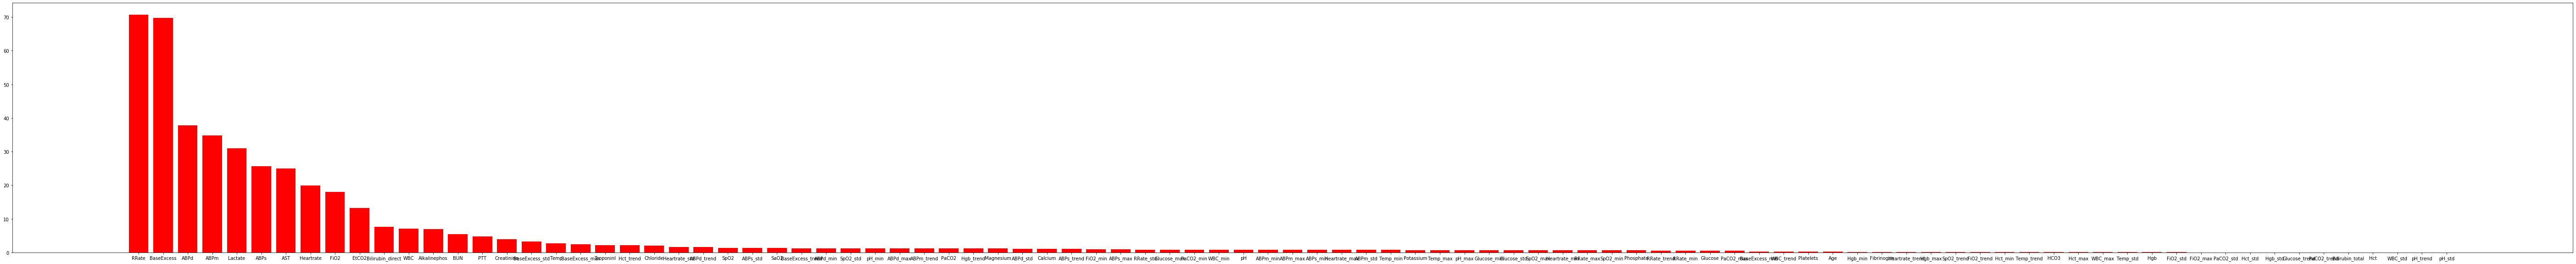

In [87]:
# feature extraction
feature_selector = SelectKBest(score_func=f_regression, k=X_train_scaled.shape[1])
fit = feature_selector.fit(X_train_scaled, y_train_sepsis[0])

# Get the indices sorted by most important to least important
indices = np.argsort(fit.scores_)[::-1]

print(indices)
# To get your top 10 feature names
features = []
for i in range(X_train_scaled.shape[1]):
    features.append(df_train.columns[indices[i]])

# Now plot
plt.rcParams['figure.figsize'] = 100, 10
plt.figure()
plt.bar(features, fit.scores_[indices[range(X_train_scaled.shape[1])]], color='r', align='center')
plt.show()

In [91]:
# Model and predict sepsis

clf = xgb.XGBClassifier(objective="binary:logistic", n_thread=-1)


X_train, X_test, y_train, y_test = train_test_split(
    X_train_scaled, y_train_sepsis[0], test_size=0.10, random_state=42, shuffle=True
)


param_grid = {
        "booster": ["dart"],
        "eta": np.arange(0,1,0.1),
        "min_child_weight": range(1, 10, 1),
        "max_depth": range(4, 10, 1),
        "gamma": range(0, 100, 1),
        "max_delta_step": range(1, 10, 1),
        "subsample": np.arange(0.1, 1, 0.05),
        "colsample_bytree": np.arange(0.3, 1, 0.05),
        "n_estimators": range(50, 150, 1),
        "scale_pos_weight": [1],
        "reg_lambda": [0, 1], # Ridge regularization
        "reg_alpha": [0, 1], # Lasso regularization
        "eval_metric": ["error"],
        "verbosity": [1]
    }

print("Resampling")
sampler = RandomUnderSampler()
X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)

print("Applying feature selection")
feature_selector = SelectKBest(score_func=f_classif, k=10)
X_train = feature_selector.fit_transform(X_train_res, y_train_res)
X_test = feature_selector.transform(X_test)


print("Fitting model")
coarse_search = RandomizedSearchCV(estimator=clf,
        param_distributions=param_grid, scoring="roc_auc",
        n_jobs=-1, cv=10, n_iter=100, verbose=1)
print(y_train_res)
coarse_search.fit(X_train, y_train_res)

sepsis_model = coarse_search.best_estimator_
print(f"ROC score on test set {roc_auc_score(y_test, coarse_search.best_estimator_.predict_proba(X_test)[:,1])}")
print(f"CV score {coarse_search.best_score_}")
print(f"Finished test for medical tests.")


Resampling
Applying feature selection
Fitting model
[0 0 0 ... 1 1 1]
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   36.8s


ROC score on test set 0.6795178031877602
CV score 0.6437475757575757
Finished test for medical tests.


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   46.3s finished


In [88]:

X_train, X_test, y_train, y_test = train_test_split(
    X_train_scaled, y_train_sepsis[0], test_size=0.10, random_state=42, shuffle=True
)

print("Resampling")
sampler = ADASYN()
X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)

print("Applying feature selection")
feature_selector = SelectKBest(score_func=f_classif, k=60)
X_train = feature_selector.fit_transform(X_train_res, y_train_res)
X_test = feature_selector.transform(X_test)

parameters = {
        "C": np.linspace(0.1, 10, num=3),
        "kernel": ["rbf", "sigmoid"],
        "gamma": np.linspace(0.1, 10, num=3),  # for poly or rbf kernel
        "coef0": [0],
        "shrinking": [True],
        "probability": [False],
        "cache_size": [1000],
        "class_weight": [None],
        "verbose": [2],
        "decision_function_shape": ["ovo"],  # only binary variables are set
        "random_state": [42],
        "max_iter": [2000]
    }

svc = SVC()
clf = GridSearchCV(svc, parameters, cv=2, n_jobs=-1)
clf.fit(X_train, y_train_res)
sepsis_model = clf.best_estimator_
print(f"ROC score on test set {roc_auc_score(y_test, sigmoid_f(clf.best_estimator_.decision_function(X_test)))}")
print(f"CV score {clf.best_score_}")
print(f"Finished test for medical tests.")

Resampling
Applying feature selection


KeyboardInterrupt: 

In [140]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import backend as K
import tensorflow as tf
from keras import optimizers

In [53]:
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight

In [ ]:
    class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
    class_weights = dict(enumerate(class_weights))

In [74]:
def get_keras_ANN_sepsis(X_train_scaled,y_train_sepsis,n_layers,hidden_units):
    X_train, X_test, y_train, y_test = train_test_split(
        X_train_scaled, y_train_sepsis[0], test_size=0.10, random_state=42, shuffle=True
    )   
    
    print("Resampling")
    sampler = ADASYN()
    X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)

    model = Sequential()
    model.add(Dense(hidden_units, activation="relu", input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.5))
    for i in range(1,n_layers):
        model.add(Dense(hidden_units, activation="relu"))
        model.add(Dropout(0.5))
    model.add(Dense(1,activation="sigmoid"))
    
    model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
    model.fit(X_train_res,y_train_res,epochs=40,batch_size=64)
    score = model.evaluate(X_test, y_test, batch_size=64)
    print("Accuracy : ",score)
    y_pred = model.predict(X_test)
    rauc = roc_auc_score(y_test, y_pred)
    print("Roc auc : ",rauc)
    

In [75]:
get_keras_ANN_sepsis(X_train_scaled, y_train_sepsis, 3, 100)

Resampling
Epoch 1/40
32011/32011 [==============================] - 1s 32us/step - loss: 0.6947 - accuracy: 0.5507
Epoch 2/40
32011/32011 [==============================] - 1s 27us/step - loss: 0.6677 - accuracy: 0.5946
Epoch 3/40
32011/32011 [==============================] - 1s 27us/step - loss: 0.6561 - accuracy: 0.6201
Epoch 4/40
32011/32011 [==============================] - 1s 28us/step - loss: 0.6443 - accuracy: 0.6317
Epoch 5/40
32011/32011 [==============================] - 1s 28us/step - loss: 0.6364 - accuracy: 0.6491
Epoch 6/40
32011/32011 [==============================] - 1s 29us/step - loss: 0.6251 - accuracy: 0.6607
Epoch 7/40
32011/32011 [==============================] - 1s 29us/step - loss: 0.6175 - accuracy: 0.6688
Epoch 8/40
32011/32011 [==============================] - 1s 30us/step - loss: 0.6081 - accuracy: 0.6808
Epoch 9/40
32011/32011 [==============================] - 1s 29us/step - loss: 0.5957 - accuracy: 0.6877
Epoch 10/40
32011/32011 [===================

In [176]:
joblib.dump(sepsis_model, f"xgboost_fine_sepsis.pkl")

['xgboost_fine_sepsis.pkl']

In [177]:
X_val_sepsis = feature_selector.transform(X_val_scaled)
y_pred = sepsis_model.predict_proba(X_val_sepsis)[:,1]
df_pred_sepsis = pd.DataFrame(y_pred, index=val_pids, columns=SEPSIS)
df_pred_sepsis = df_pred_sepsis.reset_index().rename(columns={"index": "pid"})

## Modelling vital signs

In [180]:
# Modelling of vital signs
models = []
losses = []
feature_selectors_vital_signs = []
clf = xgb.XGBRegressor(objective="reg:squarederror", n_thread=-1)

for i, sign in enumerate(VITAL_SIGNS):
    print(f"Fitting model for {sign}.")
    X_train, X_test, y_train, y_test = train_test_split(
        X_train_scaled, y_train_vital_signs[i], test_size=0.10, random_state=42, shuffle=True
    )

    print("Applying feature selection")
    feature_selector = SelectKBest(score_func=f_classif, k=5)
    X_train_selected = feature_selector.fit_transform(X_train, y_train)
    X_test_selected = feature_selector.transform(X_test)
    feature_selectors_vital_signs.append(feature_selector)

    print("Fitting model")
    
    param_grid = {
        "booster": ["dart"],
        "eta": np.arange(0,1,0.1),
        "min_child_weight": range(1, 10, 1),
        "max_depth": range(4, 10, 1),
        "gamma": range(0, 100, 1),
        "max_delta_step": range(1, 10, 1),
        "subsample": np.arange(0.1, 1, 0.05),
        "colsample_bytree": np.arange(0.3, 1, 0.05),
        "n_estimators": range(50, 150, 1),
        "scale_pos_weight": [1],
        "reg_lambda": [0, 1], # Ridge regularization
        "reg_alpha": [0, 1], # Lasso regularization
        "eval_metric": ["error"],
        "verbosity": [1]
    }


    
    coarse_search = RandomizedSearchCV(estimator=clf,
            param_distributions=param_grid, scoring="r2",
            n_jobs=-1, cv=10, n_iter=100, verbose=1)
    coarse_search.fit(X_train_selected, y_train)
    models.append(coarse_search.best_estimator_)
    print(f"CV score {coarse_search.best_score_}")
    print(f"Test score is {r2_score(y_test, coarse_search.best_estimator_.predict(X_test_selected))}")
    print(f"Finished test for medical tests.")

Fitting model for LABEL_RRate.
Applying feature selection
Fitting model
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  8.3min finished


CV score 0.3762834615674595
Test score is 0.3651876778962392
Finished test for medical tests.
Fitting model for LABEL_ABPm.
Applying feature selection
Fitting model
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  6.7min finished


CV score 0.5772479021545291
Test score is 0.5894346373011152
Finished test for medical tests.
Fitting model for LABEL_SpO2.
Applying feature selection
Fitting model
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  4.5min finished


CV score 0.30896617018979444
Test score is 0.3392388962178333
Finished test for medical tests.
Fitting model for LABEL_Heartrate.
Applying feature selection
Fitting model
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  8.0min finished


CV score 0.5974856981684256
Test score is 0.6043524041430639
Finished test for medical tests.


In [181]:
for i, model in enumerate(models):
    joblib.dump(models[i], f"xgboost_fine_{VITAL_SIGNS[i]}.pkl")

In [78]:
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

In [186]:
def get_keras_ANN_vital_signs(ind_vital_sign,X_train_scaled,y_train_vital_signs,n_layers,hidden_units,epochs):
    print(f"For vital sign {VITAL_SIGNS[ind_vital_sign]}")
    y_train_processed = []
    for i in range(len(y_train_vital_signs[ind_vital_sign])):
        y_train_processed+=[y_train_vital_signs[ind_vital_sign][i]]*12
    y_train_processed = np.array(y_train_processed)
    X_train, X_test, y_train, y_test = train_test_split(
        X_train_scaled, y_train_processed, test_size=0.10, random_state=42, shuffle=True
    )   
    score_vs,models_vs = [],[]
    for epoch in epochs:
        model = Sequential()
        model.add(Dense(hidden_units, activation="relu", input_shape=(X_train.shape[1],)))
        model.add(Dropout(0.5))
        for i in range(1,n_layers):
            model.add(Dense(hidden_units, activation="relu"))
            model.add(Dropout(0.5))
        model.add(Dense(1,activation="relu"))
        opt = optimizers.Adam()
        model.compile(optimizer=opt, loss="mse", metrics=[r2_keras])
        model.fit(X_train,y_train,epochs=int(epoch),batch_size=64)
        y_pred = model.predict(X_test, batch_size=64)
        r2s = r2_score(y_test,y_pred)
        print("final r2 : ",r2s)
        score_vs.append(r2s)
        models_vs.append(model)
    best_model = models_vs[np.argmax(score_vs)]
    print("Appended model with r2 score ",np.max(score_vs))
    return best_model

In [188]:
model_RRate = get_keras_ANN_vital_signs(0,X_train_scaled, y_train_vital_signs, 3, 100, [50])

For vital sign LABEL_RRate
[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
Epoch 1/50
205146/205146 [==============================] - 11s 56us/step - loss: 33.3013 - r2_keras: -1.8540
Epoch 2/50
205146/205146 [==============================] - 12s 56us/step - loss: 17.6482 - r2_keras: -0.4773
Epoch 3/50
205146/205146 [==============================] - 12s 59us/step - loss: 16.0369 - r2_keras: -0.3383
Epoch 4/50
205146/205146 [==============================] - 12s 58us/step - loss: 15.3659 - r2_keras: -0.2795
Epoch 5/50
205146/205146 [==============================] - 12s 56us/step - loss: 14.9129 - r2_keras: -0.2397
Epoch 6/50
205146/205146 [==============================] - 12s 58us/step - loss: 14.4199 - r2_keras: -0.1974
Epoch 7/50
205146/205146 [==============================] - 12s 58us/step - loss: 14.0649 - r2_keras: -0.1650
Epoch 8/50
205146/205146 [==============================] - 12s 57us/step - loss: 13.7796 - r2_keras: -0.1411
Epoch 9/50
205146/205146 [==================

In [189]:
model_ABPm = get_keras_ANN_vital_signs(1, X_train_scaled, y_train_vital_signs, 3, 150, [50])

For vital sign LABEL_ABPm
[104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104]
Epoch 1/50
205146/205146 [==============================] - 17s 85us/step - loss: 542.9726 - r2_keras: -2.4808
Epoch 2/50
205146/205146 [==============================] - 18s 87us/step - loss: 295.1536 - r2_keras: -0.9073
Epoch 3/50
205146/205146 [==============================] - 18s 87us/step - loss: 269.0950 - r2_keras: -0.6972
Epoch 4/50
205146/205146 [==============================] - 18s 88us/step - loss: 248.3092 - r2_keras: -0.5699
Epoch 5/50
205146/205146 [==============================] - 18s 87us/step - loss: 241.1824 - r2_keras: -0.5154
Epoch 6/50
205146/205146 [==============================] - 18s 88us/step - loss: 228.5690 - r2_keras: -0.4396
Epoch 7/50
205146/205146 [==============================] - 20s 96us/step - loss: 218.6331 - r2_keras: -0.3787
Epoch 8/50
127296/205146 [=================>............] - ETA: 6s - loss: 215.3761 - r2_keras: -0.3554

KeyboardInterrupt: 

In [145]:
model_SpO2 = get_keras_ANN_vital_signs(2, X_train_scaled, y_train_vital_signs, 4, 100, [300])

For vital sign LABEL_SpO2
Epoch 1/300
17095/17095 [==============================] - 1s 57us/step - loss: 1736.8876 - r2_keras: -512.5916
Epoch 2/300
17095/17095 [==============================] - 1s 48us/step - loss: 660.4639 - r2_keras: -193.2402
Epoch 3/300
17095/17095 [==============================] - 1s 45us/step - loss: 564.4192 - r2_keras: -163.8082
Epoch 4/300
17095/17095 [==============================] - 1s 48us/step - loss: 539.0846 - r2_keras: -162.1317
Epoch 5/300
17095/17095 [==============================] - 1s 48us/step - loss: 459.7267 - r2_keras: -132.4781
Epoch 6/300
17095/17095 [==============================] - 1s 48us/step - loss: 395.6827 - r2_keras: -115.0959
Epoch 7/300
17095/17095 [==============================] - 1s 46us/step - loss: 336.7852 - r2_keras: -97.8160
Epoch 8/300
17095/17095 [==============================] - 1s 46us/step - loss: 299.3357 - r2_keras: -86.0238
Epoch 9/300
17095/17095 [==============================] - 1s 47us/step - loss: 263.217

17095/17095 [==============================] - 1s 62us/step - loss: 109.1064 - r2_keras: -30.6315
Epoch 75/300
17095/17095 [==============================] - 1s 59us/step - loss: 108.3293 - r2_keras: -30.8074
Epoch 76/300
17095/17095 [==============================] - 1s 58us/step - loss: 106.5762 - r2_keras: -30.0614
Epoch 77/300
17095/17095 [==============================] - 1s 57us/step - loss: 107.3276 - r2_keras: -30.0037
Epoch 78/300
17095/17095 [==============================] - 1s 55us/step - loss: 108.0416 - r2_keras: -30.4520
Epoch 79/300
17095/17095 [==============================] - 1s 57us/step - loss: 107.0758 - r2_keras: -30.4207
Epoch 80/300
17095/17095 [==============================] - 1s 56us/step - loss: 106.7662 - r2_keras: -30.1006
Epoch 81/300
17095/17095 [==============================] - 1s 58us/step - loss: 102.6674 - r2_keras: -28.5975
Epoch 82/300
17095/17095 [==============================] - 1s 56us/step - loss: 102.7593 - r2_keras: -28.5199
Epoch 83/300
1

17095/17095 [==============================] - 1s 56us/step - loss: 74.2139 - r2_keras: -20.6027
Epoch 149/300
17095/17095 [==============================] - 1s 58us/step - loss: 73.6640 - r2_keras: -20.1461
Epoch 150/300
17095/17095 [==============================] - 1s 53us/step - loss: 72.5748 - r2_keras: -20.0998
Epoch 151/300
17095/17095 [==============================] - 1s 58us/step - loss: 72.9636 - r2_keras: -20.3087
Epoch 152/300
17095/17095 [==============================] - 1s 56us/step - loss: 72.2745 - r2_keras: -19.9582
Epoch 153/300
17095/17095 [==============================] - 1s 55us/step - loss: 72.0144 - r2_keras: -19.9464
Epoch 154/300
17095/17095 [==============================] - 1s 57us/step - loss: 70.5609 - r2_keras: -19.5586
Epoch 155/300
17095/17095 [==============================] - 1s 55us/step - loss: 71.5490 - r2_keras: -19.6873
Epoch 156/300
17095/17095 [==============================] - 1s 54us/step - loss: 71.2213 - r2_keras: -19.6854
Epoch 157/300
1

17095/17095 [==============================] - 1s 56us/step - loss: 52.0201 - r2_keras: -14.0563
Epoch 222/300
17095/17095 [==============================] - 1s 57us/step - loss: 50.8518 - r2_keras: -13.7355
Epoch 223/300
17095/17095 [==============================] - 1s 58us/step - loss: 51.2379 - r2_keras: -13.8218
Epoch 224/300
17095/17095 [==============================] - 1s 57us/step - loss: 50.1676 - r2_keras: -13.5117
Epoch 225/300
17095/17095 [==============================] - 1s 55us/step - loss: 49.0222 - r2_keras: -13.2696
Epoch 226/300
17095/17095 [==============================] - 1s 57us/step - loss: 50.5353 - r2_keras: -13.4521
Epoch 227/300
17095/17095 [==============================] - 1s 57us/step - loss: 49.4452 - r2_keras: -13.1759
Epoch 228/300
17095/17095 [==============================] - 1s 55us/step - loss: 48.0723 - r2_keras: -12.9299
Epoch 229/300
17095/17095 [==============================] - 1s 58us/step - loss: 48.9413 - r2_keras: -13.0814
Epoch 230/300
1

17095/17095 [==============================] - 1s 55us/step - loss: 32.8063 - r2_keras: -8.4910
Epoch 296/300
17095/17095 [==============================] - 1s 57us/step - loss: 32.5629 - r2_keras: -8.3715
Epoch 297/300
17095/17095 [==============================] - 1s 56us/step - loss: 32.0290 - r2_keras: -8.4896
Epoch 298/300
17095/17095 [==============================] - 1s 58us/step - loss: 32.4041 - r2_keras: -8.3748
Epoch 299/300
17095/17095 [==============================] - 1s 54us/step - loss: 31.9940 - r2_keras: -8.1032
Epoch 300/300
17095/17095 [==============================] - 1s 63us/step - loss: 31.9960 - r2_keras: -8.2393
final r2 :  0.16983737618729322
Appended model with r2 score  0.16983737618729322


In [147]:
model_SpO2 = new_models_vital_signs

In [148]:
model_Heartrate = get_keras_ANN_vital_signs(3, X_train_scaled, y_train_vital_signs, 3, 125, [300])

For vital sign LABEL_Heartrate
Epoch 1/300
17095/17095 [==============================] - 1s 52us/step - loss: 1219.0200 - r2_keras: -4.8700
Epoch 2/300
17095/17095 [==============================] - 1s 43us/step - loss: 492.5627 - r2_keras: -1.3833
Epoch 3/300
17095/17095 [==============================] - 1s 43us/step - loss: 425.9757 - r2_keras: -1.0468
Epoch 4/300
17095/17095 [==============================] - 1s 44us/step - loss: 412.8299 - r2_keras: -0.9796
Epoch 5/300
17095/17095 [==============================] - 1s 44us/step - loss: 369.9628 - r2_keras: -0.7764
Epoch 6/300
17095/17095 [==============================] - 1s 43us/step - loss: 351.3071 - r2_keras: -0.6732
Epoch 7/300
17095/17095 [==============================] - 1s 60us/step - loss: 334.4452 - r2_keras: -0.6026
Epoch 8/300
17095/17095 [==============================] - 1s 45us/step - loss: 317.0428 - r2_keras: -0.5235
Epoch 9/300
17095/17095 [==============================] - 1s 44us/step - loss: 301.8962 - r2_ke

17095/17095 [==============================] - 1s 75us/step - loss: 163.0536 - r2_keras: 0.2219
Epoch 76/300
17095/17095 [==============================] - 1s 66us/step - loss: 164.6682 - r2_keras: 0.2117
Epoch 77/300
17095/17095 [==============================] - 1s 61us/step - loss: 165.8784 - r2_keras: 0.2076
Epoch 78/300
17095/17095 [==============================] - 1s 64us/step - loss: 164.3541 - r2_keras: 0.2093
Epoch 79/300
17095/17095 [==============================] - 1s 65us/step - loss: 166.0693 - r2_keras: 0.1996
Epoch 80/300
17095/17095 [==============================] - 1s 66us/step - loss: 162.8675 - r2_keras: 0.2184
Epoch 81/300
17095/17095 [==============================] - 1s 66us/step - loss: 164.3367 - r2_keras: 0.2101
Epoch 82/300
17095/17095 [==============================] - 1s 58us/step - loss: 163.1601 - r2_keras: 0.2086
Epoch 83/300
17095/17095 [==============================] - 1s 57us/step - loss: 161.0324 - r2_keras: 0.2349
Epoch 84/300
17095/17095 [======

17095/17095 [==============================] - 1s 58us/step - loss: 143.7555 - r2_keras: 0.3087
Epoch 150/300
17095/17095 [==============================] - 1s 57us/step - loss: 146.1784 - r2_keras: 0.3014
Epoch 151/300
17095/17095 [==============================] - 1s 57us/step - loss: 142.0893 - r2_keras: 0.3193
Epoch 152/300
17095/17095 [==============================] - 1s 58us/step - loss: 146.4584 - r2_keras: 0.2957
Epoch 153/300
17095/17095 [==============================] - 1s 58us/step - loss: 143.4141 - r2_keras: 0.3144
Epoch 154/300
17095/17095 [==============================] - 1s 56us/step - loss: 142.6556 - r2_keras: 0.3130
Epoch 155/300
17095/17095 [==============================] - 1s 56us/step - loss: 144.7705 - r2_keras: 0.3108
Epoch 156/300
17095/17095 [==============================] - 1s 58us/step - loss: 141.9583 - r2_keras: 0.3212
Epoch 157/300
17095/17095 [==============================] - 1s 57us/step - loss: 141.0034 - r2_keras: 0.3217
Epoch 158/300
17095/1709

17095/17095 [==============================] - 1s 58us/step - loss: 128.4326 - r2_keras: 0.3859
Epoch 224/300
17095/17095 [==============================] - 1s 60us/step - loss: 127.5043 - r2_keras: 0.3907
Epoch 225/300
17095/17095 [==============================] - 1s 58us/step - loss: 127.3147 - r2_keras: 0.3913
Epoch 226/300
17095/17095 [==============================] - 1s 57us/step - loss: 129.6533 - r2_keras: 0.3795
Epoch 227/300
17095/17095 [==============================] - 1s 57us/step - loss: 127.7343 - r2_keras: 0.3886
Epoch 228/300
17095/17095 [==============================] - 1s 60us/step - loss: 127.6262 - r2_keras: 0.3860
Epoch 229/300
17095/17095 [==============================] - 1s 59us/step - loss: 128.0864 - r2_keras: 0.3814
Epoch 230/300
17095/17095 [==============================] - 1s 57us/step - loss: 128.6092 - r2_keras: 0.3873
Epoch 231/300
17095/17095 [==============================] - 1s 57us/step - loss: 126.5063 - r2_keras: 0.3975
Epoch 232/300
17095/1709

17095/17095 [==============================] - 1s 74us/step - loss: 114.2607 - r2_keras: 0.4551
Epoch 298/300
17095/17095 [==============================] - 1s 66us/step - loss: 114.0986 - r2_keras: 0.4506
Epoch 299/300
17095/17095 [==============================] - 1s 63us/step - loss: 114.5329 - r2_keras: 0.4532
Epoch 300/300
17095/17095 [==============================] - 1s 64us/step - loss: 115.1898 - r2_keras: 0.4502
final r2 :  0.5886519395272307
Appended model with r2 score  0.5886519395272307


In [150]:
models_vital_signs = [model_RRate, model_ABPm, model_SpO2, model_Heartrate]

In [182]:
# Get predictions for vital signs
df_pred_vital_signs = pd.DataFrame(index=val_pids, columns=VITAL_SIGNS)
for i, test in enumerate(VITAL_SIGNS):
    feature_selector = feature_selectors_vital_signs[i]
    X_val_vital_sign = feature_selector.transform(X_val_scaled)
    model_for_test = models[i]
    y_pred = model_for_test.predict(X_val_vital_sign)
    df_pred_vital_signs[test] = y_pred

df_pred_vital_signs = df_pred_vital_signs.reset_index().rename(columns={"index": "pid"})

In [228]:
# Get predictions for vital signs using ANN
df_pred_vital_signs = pd.DataFrame(index=val_pids, columns=VITAL_SIGNS)
for model in models_vital_signs:
    y_pred = model.predict(X_val_vital_signs)
    df_pred_vital_signs[test] = y_pred

df_pred_vital_signs = df_pred_vital_signs.reset_index().rename(columns={"index": "pid"})

ValueError: Error when checking input: expected dense_432_input to have shape (95,) but got array with shape (35,)

## Export to ZIP file

In [183]:
df_predictions = pd.merge(df_pred_medical_test, df_pred_sepsis, on="pid")
df_predictions = pd.merge(df_predictions, df_pred_vital_signs, on="pid")
print("Export predictions DataFrame to a zip file")
print(df_predictions)
df_predictions.to_csv(
    "predictions.csv",
    index=None,
    sep=",",
    header=True,
    encoding="utf-8-sig",
    float_format="%.2f",
)

with zipfile.ZipFile("predictions.zip", "w", compression=zipfile.ZIP_DEFLATED) as zf:
    zf.write("predictions.csv")
os.remove("predictions.csv")

Export predictions DataFrame to a zip file
           pid  LABEL_BaseExcess  LABEL_Fibrinogen  LABEL_AST  \
0          0.0          0.832393          0.429798   0.896758   
1          3.0          0.131074          0.304217   0.463766   
2          5.0          0.417147          0.304217   0.443913   
3          7.0          0.959387          0.911051   0.944069   
4          9.0          0.384726          0.298570   0.566566   
...        ...               ...               ...        ...   
12659  31647.0          0.338738          0.304217   0.406793   
12660  31649.0          0.175901          0.608352   0.760341   
12661  31651.0          0.929130          0.325646   0.474042   
12662  31652.0          0.082532          0.317979   0.525401   
12663  31655.0          0.117321          0.323369   0.573651   

       LABEL_Alkalinephos  LABEL_Bilirubin_total  LABEL_Lactate  \
0                0.961712               0.913878       0.849364   
1                0.480553               0.